In [1]:
import os
import datetime

import sys

sys.path.append("..")

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from functions import df_security_code, missingValues

import tensorflow as tf

from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Data

In [2]:
data = pd.read_csv('../data/curr_price_financial_fill.csv', parse_dates=['Date'],  index_col=[0])
df = df_security_code(data)
del data

In [3]:
df.head(2)

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month_sin,Month_cos,Year_sin,Year_cos,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
0,20170104_7203,2017-01-04,7203,0.0,0,7010.0,7103.0,6975.0,7097.0,9547600.0,...,0.046905,-0.998899,0.061933,0.998080,NaN,NaN,NaN,NaN,NaN,NaN
1,20170105_7203,2017-01-05,7203,0.0,0,7090.0,7091.0,7023.0,7049.0,7644000.0,...,-0.158971,-0.987283,0.079093,0.996867,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns
df = df.iloc[:,5:]
df.drop(['margin_growth', 'win_quarter_growth', 'margin', 'NetSales', 'Profit',
       'Day_cos', 'Year', 'rev_quarter_growth'], axis = 1, inplace=True)

In [5]:
df.head(2)

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
0,7010.0,7103.0,6975.0,7097.0,9547600.0,-0.016882,NaN,NaN,8.867427,7097.0,...,NaN,4.0,1.0,1.0,1.619015,-1.405899e-12,0.046905,-0.998899,0.061933,0.998080
1,7090.0,7091.0,7023.0,7049.0,7644000.0,-0.009957,7097.0,NaN,8.860641,7049.0,...,NaN,5.0,1.0,1.0,1.619015,-1.165928e-11,-0.158971,-0.987283,0.079093,0.996867


# Preparation for modelling

## - Train Test Split


In [6]:
def split_train_val_test(df, split=22):
    df.dropna(inplace=True)
    df_train =  df[:- 2*split]
    df_val = df[- 2*split : - split]
    df_test = df[- split : ]
    #

    #df_train =  df[:(len(df)-2*split)]
    #df_val = df[(len(df)-2*split):(len(df)-split)]
    #df_test =  df[(len(df)-split):]




    return df_train, df_val, df_test

In [7]:
train_data, val_data, test_data = split_train_val_test(df=df)
print(df.shape)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1169, 50)
(1125, 50)
(22, 50)
(22, 50)


In [8]:
#val_data.describe().T

## - Scaling

In [9]:
def scaling_df(df):

    scaler = StandardScaler()
    scaler2 = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = scaler2.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = df.columns
    
    #df_mean = df.mean()
    #df_std = df.std()

    #df_scaled = (df-df_mean) / df_std 
    
    return df_scaled

In [10]:
train_df = scaling_df(train_data)
val_df = scaling_df(val_data)
test_df = scaling_df(test_data)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1125, 50)
(22, 50)
(22, 50)


In [11]:
val_df.ad_Close.describe()

count    22.000000
mean      0.639177
std       0.255075
min       0.000000
25%       0.531548
50%       0.688095
75%       0.779167
max       1.000000
Name: ad_Close, dtype: float64

In [12]:
#sns.histplot(val_df.ad_Close, bins=10)

In [13]:
val_df.ad_Close.mean()

0.6391774891774893

In [14]:
val_df.describe().T.sort_values('std', ascending=True)

,count,mean,std,min,25%,50%,75%,max
Month,22.0,0.045455,0.213201,0.0,0.000000,0.000000,0.000000,1.0
ad_High_lag1,22.0,0.565073,0.235605,0.0,0.521226,0.593160,0.668042,1.0
ad_Open_lag1,22.0,0.535439,0.235689,0.0,0.396186,0.576271,0.683263,1.0
error_ad_High,22.0,0.592587,0.242696,0.0,0.485026,0.617833,0.753817,1.0
error_ad_Close,22.0,0.627733,0.247229,0.0,0.530651,0.658764,0.745712,1.0
logprice_ad_High,22.0,0.642765,0.253299,0.0,0.605412,0.686303,0.769862,1.0
ad_High,22.0,0.634775,0.253702,0.0,0.594086,0.676075,0.761425,1.0
detrend_ad_High,22.0,0.634775,0.253702,0.0,0.594086,0.676075,0.761425,1.0
ad_Volume,22.0,0.292597,0.253905,0.0,0.104625,0.225019,0.420702,1.0
error_ad_Open,22.0,0.595259,0.254375,0.0,0.431097,0.620798,0.743097,1.0


In [15]:
missingValues(train_df)
missingValues(val_df)
missingValues(test_df)

,N_missing,Percentage


,N_missing,Percentage


,N_missing,Percentage


## - Window

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #self.example = 

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [17]:
#w1 = WindowGenerator(input_width=22, label_width=1, shift=1,
                     #label_columns=['ad_Close'])
#w1

In [18]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [19]:
"""example_window = tf.stack([np.array(train_data[:w1.total_window_size]),
                           np.array(train_data[100:100+w1.total_window_size]),
                           np.array(train_data[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')"""

"example_window = tf.stack([np.array(train_data[:w1.total_window_size]),\n                           np.array(train_data[100:100+w1.total_window_size]),\n                           np.array(train_data[200:200+w1.total_window_size])])\n\nexample_inputs, example_labels = w1.split_window(example_window)\n\nprint('All shapes are: (batch, time, features)')\nprint(f'Window shape: {example_window.shape}')\nprint(f'Inputs shape: {example_inputs.shape}')\nprint(f'Labels shape: {example_labels.shape}')"

In [20]:
#w1.example = example_inputs, example_labels

In [21]:
def plot(self, model=None, plot_col='ad_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [22]:
#w1.plot()

In [23]:
#w1.plot(plot_col='ad_Target')

### create dataset

In [24]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

### train , val , test

In [25]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [26]:
# Each element is an (inputs, label) pair.
#w1.train.element_spec

In [27]:
"""for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')"""

"for example_inputs, example_labels in w1.train.take(1):\n  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')\n  print(f'Labels shape (batch, time, features): {example_labels.shape}')"

# Modelling

### - Baseline

In [28]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

### - Linear

In [29]:
linear = tf.keras.Sequential([
    #tf.keras.layers.Normalization(axis=None), 

    tf.keras.layers.Dense(units=1)
])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-04-27 20:26:20.748641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 20:26:20.748735: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### helper functions


In [30]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [31]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    #mode='min'
                                                    )

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping]
                      )
  return history

In [32]:
train_performance ={}
val_performance = {}
performance = {}

# Fit Test


## - Single step models:

predict a single features value 1 time step into future

In [33]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ad_Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ad_Close']

In [34]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 50)
Labels shape (batch, time, features): (32, 1, 1)


2022-04-27 20:26:21.101808: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


- Baseline

In [35]:
"""class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]"""

'class Baseline(tf.keras.Model):\n  def __init__(self, label_index=None):\n    super().__init__()\n    self.label_index = label_index\n\n  def call(self, inputs):\n    if self.label_index is None:\n      return inputs\n    result = inputs[:, :, self.label_index]\n    return result[:, :, tf.newaxis]'

In [36]:
baseline = Baseline(label_index=single_step_window.column_indices['ad_Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


train_performance['Baseline_S'] = baseline.evaluate(single_step_window.train)
val_performance['Baseline_S'] = baseline.evaluate(single_step_window.val)
performance['Baseline_S'] = baseline.evaluate(single_step_window.test, verbose=0)

24/36 [===================>..........] - ETA: 0s - loss: 4.9304e-04 - mean_absolute_error: 0.0158

2022-04-27 20:26:21.348878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 28ms/step - loss: 0.0265 - mean_absolute_error: 0.1333


In [37]:
"""wide_window = WindowGenerator(
    input_width=22, label_width=1, shift=1,
    label_columns=['ad_Close'])
wide_window"""

"wide_window = WindowGenerator(\n    input_width=22, label_width=1, shift=1,\n    label_columns=['ad_Close'])\nwide_window"

In [38]:
"""wide_window = WindowGenerator(
    input_width=22, label_width=22, shift=1,
    label_columns=['ad_Close'])
# baseline wide window
baseline_w = Baseline(label_index=wide_window.column_indices['ad_Close'])

baseline_w.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline_w.evaluate(wide_window.val)
performance['Baseline'] = baseline_w.evaluate(wide_window.test, verbose=0)"""

"wide_window = WindowGenerator(\n    input_width=22, label_width=22, shift=1,\n    label_columns=['ad_Close'])\n# baseline wide window\nbaseline_w = Baseline(label_index=wide_window.column_indices['ad_Close'])\n\nbaseline_w.compile(loss=tf.losses.MeanSquaredError(),\n                 metrics=[tf.metrics.MeanAbsoluteError()])\n\nval_performance = {}\nperformance = {}\nval_performance['Baseline'] = baseline_w.evaluate(wide_window.val)\nperformance['Baseline'] = baseline_w.evaluate(wide_window.test, verbose=0)"

### - linear

In [39]:
"""linear = tf.keras.Sequential([
    tf.keras.layers.Normalization(axis=None), 
    tf.keras.layers.Dense(units=1)
])"""

'linear = tf.keras.Sequential([\n    tf.keras.layers.Normalization(axis=None), \n    tf.keras.layers.Dense(units=1)\n])'

In [40]:
"""MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history"""

"MAX_EPOCHS = 20\n\ndef compile_and_fit(model, window, patience=2):\n  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\n                                                    patience=patience,\n                                                    mode='min')\n\n  model.compile(loss=tf.losses.MeanSquaredError(),\n                optimizer=tf.optimizers.Adam(),\n                metrics=[tf.metrics.MeanAbsoluteError()])\n\n  history = model.fit(window.train, epochs=MAX_EPOCHS,\n                      validation_data=window.val,\n                      callbacks=[early_stopping])\n  return history"

In [41]:
history_l_s = compile_and_fit(linear, single_step_window)

##val_performance['Linear'] = linear.evaluate(w1.val)
#performance['Linear'] = linear.evaluate(w1.test, verbose=0)

Epoch 1/20
23/36 [==================>...........] - ETA: 0s - loss: 0.6329 - mean_absolute_error: 0.7045

2022-04-27 20:26:22.136301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 10ms/step - loss: 0.4916 - mean_absolute_error: 0.5979 - val_loss: 0.6172 - val_mean_absolute_error: 0.6742
Epoch 2/20
22/36 [=================>............] - ETA: 0s - loss: 0.0792 - mean_absolute_error: 0.2266

2022-04-27 20:26:22.517924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 6ms/step - loss: 0.0698 - mean_absolute_error: 0.2107 - val_loss: 0.4272 - val_mean_absolute_error: 0.5024
Epoch 3/20
36/36 [==============================] - 0s 6ms/step - loss: 0.0475 - mean_absolute_error: 0.1750 - val_loss: 0.4127 - val_mean_absolute_error: 0.4882
Epoch 4/20
36/36 [==============================] - 0s 6ms/step - loss: 0.0435 - mean_absolute_error: 0.1677 - val_loss: 0.3991 - val_mean_absolute_error: 0.4778
Epoch 5/20
36/36 [==============================] - 0s 5ms/step - loss: 0.0400 - mean_absolute_error: 0.1609 - val_loss: 0.3843 - val_mean_absolute_error: 0.4649
Epoch 6/20
36/36 [==============================] - 0s 6ms/step - loss: 0.0367 - mean_absolute_error: 0.1544 - val_loss: 0.3698 - val_mean_absolute_error: 0.4530
Epoch 7/20
36/36 [==============================] - 0s 6ms/step - loss: 0.0337 - mean_absolute_error: 0.1485 - val_loss: 0.3536 - val_mean_absolute_error: 0.4383
Epoch 8/20
36/36 [=====================

In [42]:
pd.DataFrame(history_l_s.history)



,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.491619,0.597891,0.617186,0.674223
1,0.069792,0.210736,0.427181,0.502434
2,0.047502,0.174958,0.412652,0.488220
3,0.043537,0.167661,0.399091,0.477754
4,0.040002,0.160902,0.384268,0.464946
5,0.036713,0.154388,0.369776,0.453013
6,0.033745,0.148480,0.353633,0.438317
7,0.030913,0.141865,0.339303,0.429455
8,0.028540,0.136204,0.325968,0.422666
9,0.026334,0.131117,0.312759,0.415214


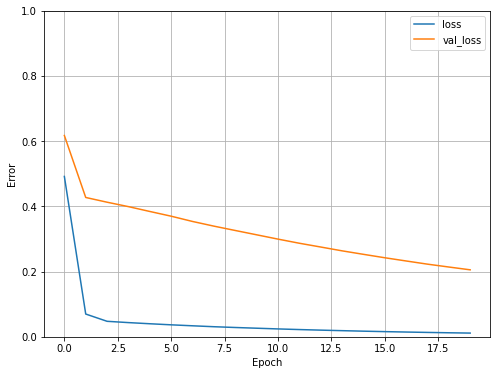

In [43]:
plot_loss(history_l_s)

In [44]:
#single_step_window.plot(linear)

In [45]:
"""plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)"""

'plt.bar(x = range(len(train_df.columns)),\n        height=linear.layers[0].kernel[:,0].numpy())\naxis = plt.gca()\naxis.set_xticks(range(len(train_df.columns)))\n_ = axis.set_xticklabels(train_df.columns, rotation=90)'

In [46]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 1, 50), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [47]:
type(single_step_window.train.get_single_element)

method

In [48]:
type(single_step_window.train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [49]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(type(example_inputs))
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 50)
<class 'tensorflow.python.framework.ops.EagerTensor'>
Labels shape (batch, time, features): (32, 1, 1)


In [50]:
train_performance['Linear_S'] = linear.evaluate(single_step_window.train)

36/36 [==============================] - 0s 7ms/step - loss: 0.0108 - mean_absolute_error: 0.0828


In [51]:
val_performance['Linear_S'] = linear.evaluate(single_step_window.val)

1/1 [==============================] - 0s 31ms/step - loss: 0.2053 - mean_absolute_error: 0.3543


In [52]:
performance['Linear_S'] = linear.evaluate(single_step_window.test, verbose=0)

In [53]:
train_performance['Linear_S'] = linear.evaluate(single_step_window.train)
val_performance['Linear_S'] = linear.evaluate(single_step_window.val)
performance['Linear_S'] = linear.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 29ms/step - loss: 0.2053 - mean_absolute_error: 0.3543


In [54]:
performance

{'Baseline_S': [0.03862707316875458, 0.16349747776985168],
 'Linear_S': [0.13398684561252594, 0.3218185305595398]}

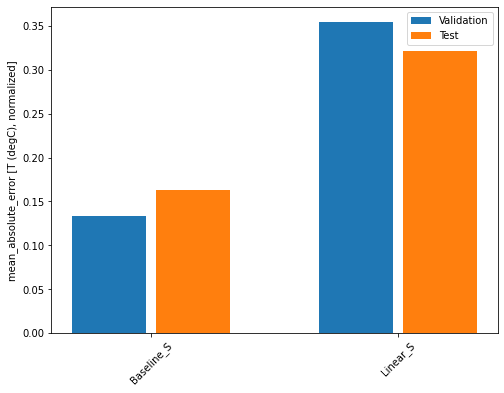

In [55]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = linear.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]
train_mae = [v[metric_index] for v in train_performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## - w1

In [56]:
w1 = WindowGenerator(input_width=22, label_width=1, shift=1,
                     label_columns=['ad_Close'])

In [57]:
example_window = tf.stack([np.array(train_data[:w1.total_window_size]),
                           np.array(train_data[100:100+w1.total_window_size]),
                           np.array(train_data[200:200+w1.total_window_size])])
#example_inputs, example_labels = w1.split_window(example_window)

In [58]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 22, 50)
Labels shape (batch, time, features): (32, 1, 1)


In [59]:
#w1.example = example_inputs, example_labels

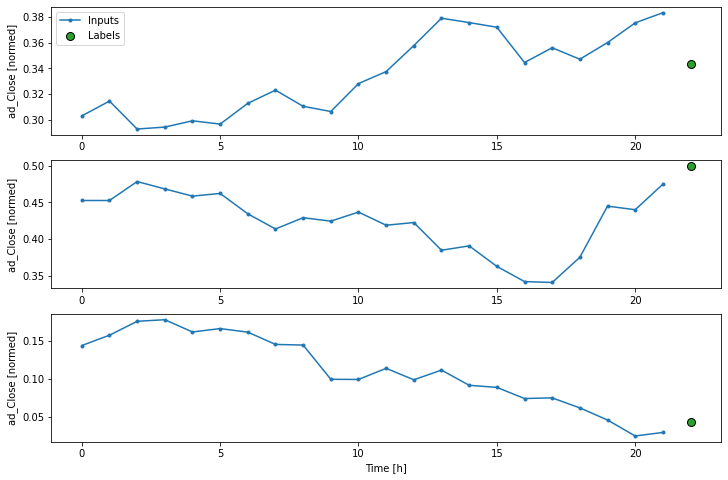

In [60]:
w1.plot()

In [61]:
w1.train.element_spec

(TensorSpec(shape=(None, 22, 50), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [62]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(type(example_inputs))
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 22, 50)
<class 'tensorflow.python.framework.ops.EagerTensor'>
Labels shape (batch, time, features): (32, 1, 1)


In [63]:
len(example_inputs)

32

In [64]:
history_b_w = compile_and_fit(baseline, w1)

Epoch 1/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 2/20
 1/35 [..............................] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0444

2022-04-27 20:26:29.483138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 3/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 4/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 5/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 6/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 7/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 8/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 9/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 10/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 11/20
35/35 [==========

In [65]:
pd.DataFrame(history_b_w.history)

,loss,mean_absolute_error
0,0.004709,0.049164
1,0.004709,0.049164
2,0.004709,0.049164
3,0.004709,0.049164
4,0.004709,0.049164
5,0.004709,0.049164
6,0.004709,0.049164
7,0.004709,0.049164
8,0.004709,0.049164
9,0.004709,0.049164


In [66]:

#val_performance['Baseline'] = baseline.evaluate(w1.val)
performance['Baseline_w'] = baseline.evaluate(example_inputs,example_labels , verbose=0)

2022-04-27 20:26:32.692018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [67]:
#baseline.predict(example_inputs)

In [68]:
w1.train

<MapDataset element_spec=(TensorSpec(shape=(None, 22, 50), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [77]:
history_l_w = compile_and_fit(linear, w1)
#performance['Linear_w'] = linear.evaluate(example_inputs,example_labels , verbose=0)

Epoch 1/20
21/35 [=================>............] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0424

2022-04-27 20:28:44.460193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0420
Epoch 2/20
35/35 [==============================] - 0s 11ms/step - loss: 0.0031 - mean_absolute_error: 0.0414
Epoch 3/20
35/35 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0404
Epoch 4/20
35/35 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0402
Epoch 5/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0392
Epoch 6/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0392
Epoch 7/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0384
Epoch 8/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0382
Epoch 9/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0382
Epoch 10/20
35/35 [==========

In [70]:
pd.DataFrame(history_l_w.history)

,loss,mean_absolute_error
0,0.016328,0.100415
1,0.012531,0.086853
2,0.010416,0.078212
3,0.009007,0.072286
4,0.007891,0.067265
5,0.007128,0.063502
6,0.006414,0.060100
7,0.005894,0.057315
8,0.005571,0.055691
9,0.005090,0.052959


In [71]:
#plot_loss(history_l_w)

In [72]:
for example_inputs, example_labels in w1.test.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(type(example_inputs))
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
train_performance['Linear_w'] = linear.evaluate(w1.train)
#val_performance['Linear_w'] = linear.evaluate(w1.val)
#performance['Linear_w'] = linear.evaluate(example_inputs,example_labels)
#performance['Linear_w'] = linear.evaluate(w1.test)

In [74]:
performance

{'Baseline_S': [0.03862707316875458, 0.16349747776985168],
 'Linear_S': [0.13398684561252594, 0.3218185305595398],
 'Baseline_w': [0.007081523071974516, 0.05763290449976921]}

In [ ]:
'''x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = linear.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x , val_mae, width, label='Validation')
plt.bar(x , test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()'''

In [ ]:
pd.DataFrame(performance, index=['Mean Squared Error [ad_Close]', 'Mean Absolute error [ad_Close]']).T
